# PHYS 325 Scientific Computing -- Fall 2018

### 2.3.4 Data fitting

#### Least squares

Minimize

$$
\chi^2 = \sum_{i=1}^N \left( \, {y_i - f(x_i) \over \sigma_i } \, \right)^2,
$$

where $f(x)$ is the fitting function

#### Which $\chi^2$ values are "good enough"?

Simple estimate:

- assume normally distributed measurement errors
- we want most data points to be about $1\sigma$ away from the true value
- this would mean that $\chi^2$ should be approximately $N$
- but the best fit parameters are not statistically independent (if we take enough parameters we can fit anything through our data)
  
- consider instead

  **degrees of freedom**: $\nu = N-M$
  <br>
  
- compute $\chi^2/\nu$
     - it should be close to 1
     - values between 0 and 2 indicate a good fit
     - values that are too high indicate a bad fit (inappropriate fit function, too few parameters, errors underestimated)
     - values too close to 0 indicate overfitting (too many parameters, errors overestimated)
- if the errors $\sigma_i$ are unknown: use $\sigma_i=1$ (in this case we *cannot assess the goodness of fit*)

More precise estimate:

- for linear models: around minimum we have $\chi^2$ distribution for $N-M$ degrees of freedom
- probability $Q = \Gamma_Q(\nu/2,\chi^2_{\rm min}/2)$ that the chi-square should exceed a particular value by chance
- $\Gamma_Q(s,x)$ is the [regularized upper incomplete gamma function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gammaincc.html)
- can work with this even for nonlinear models
- $Q$ should be reasonably close to 1
     - usually want values $Q\gtrsim 0.1$
     - might accept fits with $Q>0.001$
     - rejected fits often have really small $Q$, e.g. around $10^{-12}$
     - $Q$ values that are too close to 1 might indicate overfitting

**Fitting data to a straight line** (linear regression)

$$f(x) = a + bx$$

Example, data from O. Goulko and M. Wingate, <i>"Thermodynamics of balanced and slightly spin-imbalanced Fermi gases at unitarity"</i>, <a href="http://pra.aps.org/abstract/PRA/v82/i5/e053621">Phys. Rev. A 82, 053621 (2010)</a>, eprint <a href="http://arxiv.org/abs/1008.3348">arXiv:1008.3348</a>

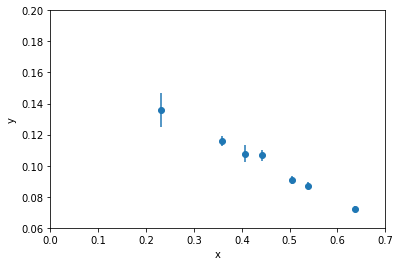

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# data from 
# legend: x, sigmax, y, sigmay
myData = np.array([[0.6359, 0.0028, 0.0724, 0.0016],
                   [0.5379, 0.0028, 0.0871, 0.0021],
                   [0.5055, 0.0032, 0.0907, 0.0026],
                   [0.4423, 0.0030, 0.1067, 0.0035],
                   [0.4066, 0.0051, 0.1078, 0.0052],
                   [0.3581, 0.0028, 0.1159, 0.0032],
                   [0.2319, 0.0058, 0.1358, 0.0110]])
x = myData[:,0]
y = myData[:,2]
sigmax = myData[:,1]
sigmay = myData[:,3]

plt.errorbar(x, y, yerr=sigmay, fmt='o')
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 0.7)
plt.ylim(0.06, 0.2)
plt.show()

In [12]:
def chisq(params):
    a, b = params
    return np.sum( (a + b*x - y)**2/sigmay**2 )

initial_guess = [0.16, -5]
minimize(chisq, initial_guess)

      fun: 2.0030757432000352
 hess_inv: array([[ 1.62381261e-05, -2.92082778e-05],
       [-2.92082778e-05,  5.42251081e-05]])
      jac: array([5.96046448e-08, 8.94069672e-08])
  message: 'Optimization terminated successfully.'
     nfev: 32
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([ 0.17291389, -0.15861776])

In [13]:
from scipy.special import gammaincc

dof = len(myData) - 2
chisq_min = minimize(chisq, initial_guess).fun

print("chisq_min/dof = ", chisq_min/dof)
print("Q = ", gammaincc(dof/2, chisq_min/2))

chisq_min/dof =  0.400615148640007
Q =  0.8487192846484906


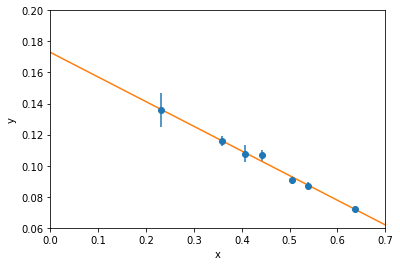

In [14]:
plt.errorbar(x, y, yerr=sigmay, fmt='o')

best_fit = minimize(chisq, initial_guess).x
x_for_plot = np.linspace(0, 0.7, 100)
plt.plot(x_for_plot, best_fit[0] + best_fit[1]*x_for_plot)

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 0.7)
plt.ylim(0.06, 0.2)

plt.show()

We can also find the minimum **analytically** (by solving $\partial\chi^2/\partial a = \partial\chi^2/\partial b = 0$)

Define

$$
\begin{align}
S &\equiv& \sum_{i=1}^N\frac{1}{\sigma_i^2}\\
S_x &\equiv& \sum_{i=1}^N\frac{x_i}{\sigma_i^2}\\
S_y &\equiv& \sum_{i=1}^N\frac{y_i}{\sigma_i^2}\\
t_i &\equiv& \frac{1}{\sigma_i}\left(x_i-\frac{S_x}{S}\right)\\
S_{tt} &\equiv& \sum_{i=1}^N t_i^2
\end{align}
$$

Then

$$
\begin{align}
b &=& \frac{1}{S_{tt}}\sum_{i=1}^N\frac{t_iy_i}{\sigma_i}\\
a &=& \frac{S_y-S_xb}{S}
\end{align}
$$

(see "Numerical Recipes" for derivation)

In [15]:
S = np.sum(1/sigmay/sigmay)
Sx = np.sum(x/sigmay/sigmay)
Sy = np.sum(y/sigmay/sigmay)
t = (x-Sx/S)/sigmay
Stt = np.sum(t*t)

b = np.sum(t*y/sigmay)/Stt
a = (Sy-Sx*b)/S
print('[ %.8f' % a, '%.8f' % b, ']')
print(best_fit)

[ 0.17291400 -0.15861795 ]
[ 0.17291389 -0.15861776]


Errors on the fit coefficients:

$$
\begin{align}
\sigma_a^2 &=& \frac{1}{S}\left(1+\frac{S_x^2}{SS_{tt}}\right)\\
\sigma_b^2 &=& \frac{1}{S_{tt}}
\end{align}
$$

(see "Numerical Recipes" for derivation)

In [16]:
error_on_a = np.sqrt((1+Sx*Sx/S/Stt)/S)
error_on_b = np.sqrt(1/Stt)

print("a = ", a, "+-", error_on_a, "\nb =", b, "+-", error_on_b)

a =  0.17291400480869254 +- 0.005698795029183341 
b = -0.15861794692190379 +- 0.010413945532988245


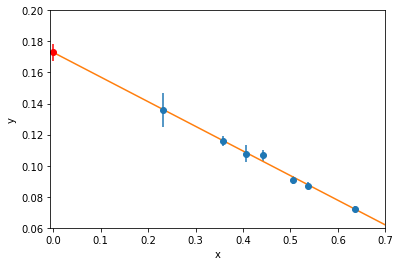

In [17]:
plt.errorbar(x, y, yerr=sigmay, fmt='o')
plt.errorbar(0, best_fit[0], yerr=error_on_a, fmt='ro')
plt.plot(x_for_plot, best_fit[0] + best_fit[1]*x_for_plot)

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.006, 0.7)
plt.ylim(0.06, 0.2)

plt.show()

In [18]:
# same as above using the numpy.polyfit routine

print(np.polyfit(x, y, 1, full=True, w=1/sigmay, cov=True),"\n")

fit_coeffs, fit_cov = np.polyfit(x, y, 1, full=False, w=1/sigmay, cov=True)

# unfortunately, the polyfit routine outputs the errors incorrectly
# to get the correct error bars we need to divide the covariance matrix fit_cov by χ2/(ν-2) ...

fit_cov = fit_cov/ (chisq_min/ (dof-2))

# part of the reason is explained in Appendix D of Peter Young's article
# if you are interested in the reason behind the additional -2, see for example here:
# https://stackoverflow.com/questions/51980910/scipy-curve-fit-vs-numpy-polyfit-different-covariance-matrices

print("Printing the polyfit fit result:")
# note that the order of the fit coefficients is also different!
print("\na = ", fit_coeffs[1], "+-", np.sqrt(fit_cov[1][1]),\
      "\nb =", fit_coeffs[0], "+-", np.sqrt(fit_cov[0][0]))

print("\nResults from the exact formula:")
print("\na = ", a, "+-", error_on_a, "\nb =", b, "+-", error_on_b)

(array([-0.15861795,  0.172914  ]), array([2.00307574]), 2, array([1.40866012, 0.12520645]), 1.5543122344752192e-15) 

Printing the polyfit fit result:

a =  0.17291400480869343 +- 0.005698795028625046 
b = -0.1586179469219054 +- 0.010413945531968017

Results from the exact formula:

a =  0.17291400480869254 +- 0.005698795029183341 
b = -0.15861794692190379 +- 0.010413945532988245


In [19]:
# same as above using the scipy.optimize.curve_fit routine
# this general routine works also for nonlinear fits, as we will see later

from scipy.optimize import curve_fit

# define function we want to fit to, in this case linear
def fit_func(x, a, b):
    return a + b*x

# in order to get correct error bars we need to set absolute_sigma=True !!!
popt, pcov = curve_fit(fit_func, x, y, sigma = sigmay, absolute_sigma=True)

print("\nBest fit parameters: ", popt)
print("Errors on fit parameters: ", np.sqrt(np.diag(pcov)))


Best fit parameters:  [ 0.172914   -0.15861795]
Errors on fit parameters:  [0.00569879 0.01041395]


**Data errors in both coordinates**

$$
\chi^2 = \sum_{i=1}^N {(y_i - a - bx_i)^2 \over \sigma_{y,i}^2 + b^2\sigma_{x,i}^2 }
$$

This is true because of the properties of the variance

$$ {\rm Var} (aX+bY+c)=a^{2}{\rm Var} (X)+b^{2}{\rm Var} (Y)+2ab\,{\rm Cov} (X,Y)$$

and hence

$${\rm Var}(y_i - a - bx_i) = {\rm Var}(y_i) + b^2{\rm Var}(x_i) = \sigma_{y,i}^2 + b^2\sigma_{x,i}^2$$

for independent errors

In [49]:
def chisq(params):
    a, b = params
    return np.sum( (a + b*x - y)**2/ (sigmay**2 + b*b*sigmax**2) )

initial_guess = [0.2, -1]
minimize(chisq, initial_guess)

      fun: 1.9512009993135009
 hess_inv: array([[ 1.68428055e-05, -3.03958590e-05],
       [-3.03958590e-05,  5.66377164e-05]])
      jac: array([-5.96046448e-08,  1.93715096e-07])
  message: 'Optimization terminated successfully.'
     nfev: 64
      nit: 12
     njev: 16
   status: 0
  success: True
        x: array([ 0.17298943, -0.15875628])

In [50]:
chisq_min_withxerrors = minimize(chisq, initial_guess).fun

print("chisq_min/dof = ", chisq_min_withxerrors/dof)
print("Q = ", gammaincc(dof/2, chisq_min_withxerrors/2))

chisq_min/dof =  0.3902401998627002
Q =  0.8558552840382943


(0.06, 0.2)

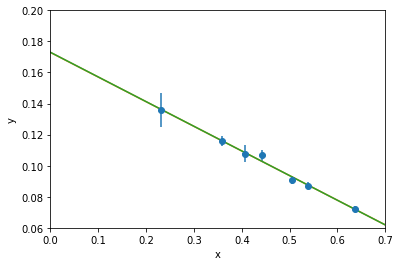

In [51]:
plt.figure()
plt.errorbar(x, y, xerr = sigmax, yerr = sigmay, fmt='o')

best_fit_withxerrors = minimize(chisq, initial_guess).x
plt.plot(x_for_plot, best_fit[0] + best_fit[1]*x_for_plot)
plt.plot(x_for_plot, best_fit_withxerrors[0] + best_fit_withxerrors[1]*x_for_plot)

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 0.7)
plt.ylim(0.06, 0.2)

- no longer an easy analytic solution for $a$ and $b$ (because $\partial\chi^2/\partial b=0$ is a nonlinear equation!)
- we can only exactly express $a$ as a function of $b$

$$a = \frac{\sum_{i=1}^N w_i(y_i-bx_i)}{\sum_{i=1}^N w_i}\ \ {\rm where }\ \ w_i=\frac{1}{\sigma_{y,i}^2 + b^2\sigma_{x,i}^2}$$

- need to minimize $\chi^2$ numerically, but can use formula above to simplify the function
- finding the standard errors on $a$ and $b$ is much more complicated:

<br>

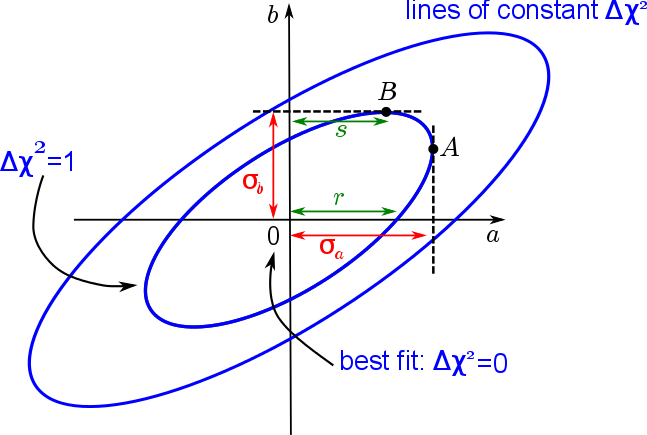

<div style="text-align: right"> figure adapted from "Numerical Recipes" </div>

> A contour of constant $\Delta\chi^2$ as the boundary of a confidence region 

For normally distributed errors: 

This table shows the values of $\Delta\chi^2$ as function of confidence level $p$ and number of fit parameters $\nu$ on which we need an error estimate

$$
\begin{array}{|l|llllll|}
\hline
       &      &      & \nu  &      &      &     \\
p      & 1    & 2    & 3    & 4    & 5    & 6    \\       \hline
68.3\%  & 1.00 & 2.30 & 3.53 & 4.72 & 5.89 & 7.04 \\
90\%    & 2.71 & 4.61 & 6.25 & 7.78 & 9.24 & 10.6 \\
95.4\%  & 4.00 & 6.17 & 8.02 & 9.70 & 11.3 & 12.8 \\
99\%    & 6.63 & 9.21 & 11.3 & 13.3 & 15.1 & 16.8 \\
99.73\% & 9.00 & 11.8 & 14.2 & 16.3 & 18.2 & 20.1 \\
99.99\% & 15.1 & 18.4 & 21.1 & 23.5 & 25.7 & 27.8 \\ \hline
\end{array}
$$

Example:

> $\Delta\chi^2 = 1$ corresponds to the "standard" 68.3% confidence interval on *the intercept* for a linear fit

Strategy:

- find the best fit first, by using a minimization routine
- then map out the $\Delta\chi^2 = 1$ contour numerically
- this corresponds to solving a nonlinear equation
- we can use the geometric fact $\sigma_a^2 = r^2+s^2$, see picture:
     - first find point $B$ in the picture
     - for this we need the maximal value of $b$ so that $\Delta\chi^2 = \chi^2 - \chi^2_{\rm min} = 1$ (remember that we have a formula that gives us $a$ as a function of $b$)
     - this gives us $\sigma_b$ and the distance $s$ in the picture
     - then keep $b$ fixed (at its "best value") and vary $a$ until we reach $\Delta\chi^2 = \chi^2 - \chi^2_{\rm min} = 1$
     - this gives us the distance $r$ in the picture
     - we also have an exact formula for $r$:
     $$r^2 = \frac{1}{\sum_{i=1}^N w_i}$$
     - and we can get $\sigma_a$ with the geometric formula!

[ 0.17298943 -0.15875628]
True


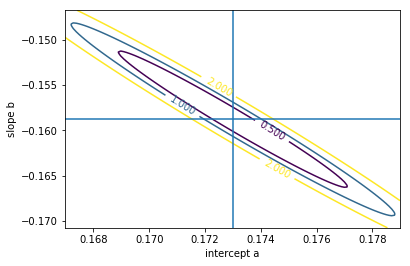

In [12]:
def chisq(params):
    a, b = params
    return np.sum( (a + b*x - y)**2/ (sigmay**2 + b*b*sigmax**2) )

def w(b):
    return 1/ (sigmay**2 + b*b*sigmax**2)

def a_exact(b):
    return np.sum(w(b)*(y-b*x))/np.sum(w(b))

def r_squared(b):
    return 1/np.sum(w(b))

# our best fit from before
print(best_fit_withxerrors)

# check exact formula for a
print(np.allclose(best_fit_withxerrors[0], a_exact(best_fit_withxerrors[1])))

# plot Δχ2 contours
delta_a = 0.006
delta_b = 0.012
a = np.arange(best_fit_withxerrors[0]-delta_a, best_fit_withxerrors[0]+delta_a, 0.0001)
b = np.arange(best_fit_withxerrors[1]-delta_b, best_fit_withxerrors[1]+delta_b, 0.0001)

delta_chisq = np.zeros((len(b), len(a)))
for i in range(len(a)):
    for j in range(len(b)):
        delta_chisq[j, i] = np.sum( (a[i] + b[j]*x - y)**2/(sigmay**2 + b[j]*b[j]*sigmax**2) ) - chisq_min_withxerrors

chi_contours = plt.contour(a, b, delta_chisq, levels = [0.5, 1, 2])
plt.clabel(chi_contours, inline=1, fontsize=10)
plt.axvline(x = best_fit_withxerrors[0])
plt.axhline(y = best_fit_withxerrors[1])
plt.xlabel("intercept a")
plt.ylabel("slope b")
plt.show()

sigma_b =  0.010680000000010681
sigma_b =  0.010413945532988245  (previously calculated: errors only in y-coordinates)
True
sigma_a =  0.005820135267778545
sigma_a =  0.005698795029183341  (previously calculated: errors only in y-coordinates)


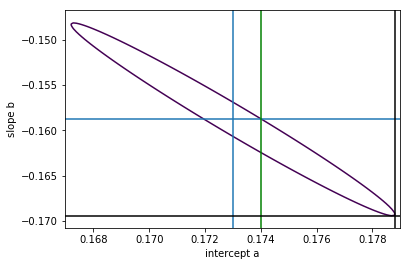

In [15]:
# find point B on the plot
current_chisq = chisq_min_withxerrors
current_b = best_fit_withxerrors[1]
while current_chisq < chisq_min_withxerrors + 1:
    current_b -= 0.00001      # I chose negative sign for the lower right corner, but plus sign works equally well
    current_params = a_exact(current_b), current_b
    current_chisq = chisq(current_params)

sigmab = current_b - best_fit_withxerrors[1]
print("sigma_b = ", abs(sigmab))
print("sigma_b = ", error_on_b, " (previously calculated: errors only in y-coordinates)")

# this automatically gives us the distance s
s = a_exact(current_b) - best_fit_withxerrors[0]

# find distance r on the plot explicitly
current_chisq = chisq_min_withxerrors
current_a = best_fit_withxerrors[0]
while current_chisq < chisq_min_withxerrors + 1:
    current_a += 0.0000001
    current_params = current_a, best_fit_withxerrors[1]
    current_chisq = chisq(current_params)

r = current_a - best_fit_withxerrors[0]

# compare with exact formula
print(np.isclose(r*r, r_squared(best_fit_withxerrors[1]), 1e-6))

# finally, get error on the intercept
print("sigma_a = ", np.sqrt(r*r + s*s))
print("sigma_a = ", error_on_a, " (previously calculated: errors only in y-coordinates)")

# plot in relation to Δχ2=1 contour
chi_contours = plt.contour(a, b, delta_chisq, levels = 1)
plt.axvline(x = best_fit_withxerrors[0])
plt.axhline(y = best_fit_withxerrors[1])

plt.axvline(x = r + best_fit_withxerrors[0], color = 'g')
plt.axvline(x = np.sqrt(r*r + s*s) + best_fit_withxerrors[0], color = 'k')
plt.axhline(y = sigmab + best_fit_withxerrors[1], color = 'k')

plt.xlabel("intercept a")
plt.ylabel("slope b")
plt.show()

#### Exponentials and power laws

Often nonlinear functions can be made linear, e.g.:

$$f(x) = a x^d \ \ \ {\rm with}\ \ {\rm constant }\ \ \ a, d$$

Take the logarithm of both sides of the equation:

$$\log(f) = \log(a) + d \log(x)$$

=> linear fit on a log-log scale

Similar: log-scale for exponentials

$$f(x) = a \exp(-bx)\Rightarrow\log(f) = \log(a) -bx$$

=> linear fit on a log scale

#### General linear least squares

In the same way as before, we can fit to a linear combination of *any* $M$ specified functions of $x$!

Most common: polynomials, in particular low order

$$y(x)=a_1+a_2x+a_3x^2\ldots+a_Mx^{M-1}$$

But the functions can also be more complicated, e.g.

$$y(x) = a_1\log(x) + a_1\sin(x)\cos(x) + a_2\exp(-x^2+15)+\ldots$$

General formula:

$$y(x)=\sum_{k=1}^Ma_kX_{k}(x)$$

where the (arbitrary) functions $X_k(x)$ are called **basis functions**

- the functions $X_k(x)$ **do not have to be linear**
- only the **combination** (dependence on the fit parameters) is linear

As before, minimize

$$
\chi^2=\sum_{i=1}^N\left(\frac{y_i-\sum_{k=1}^Ma_kX_{k}(x_i)}{\sigma_i}\right)^2
$$

Now we need to solve for many parameters: $a_1,\ldots,a_M$

=> but the dependence on the $a_k$ is linear

=> a linear expression in many parameters implies ...

<br><br><br>

... we have seen this before ...

<br><br><br>

... a system of linear equations! big matrices! linear algebra!

First we will write our $\chi^2$ in convenient **matrix notation**

$$A_{ij}=\frac{X_j(x_i)}{\sigma_i}$$

- the matrix $A$ is called the **design matrix** of the fitting problem
- remember that we know all $X_j(x_i)$ (the unknown fit parameters are not part of $X_j$)
- we need to have more data points than fit parameters: $N>M$ and hopefully $N\gg M$

=> the design matrix has more rows than columns

$$A=
\begin{pmatrix}
\frac{X_1(x_1)}{\sigma_1} & \ldots & \frac{X_M(x_1)}{\sigma_1} \\
\frac{X_1(x_2)}{\sigma_2} & \ldots & \frac{X_M(x_2)}{\sigma_2} \\
\vdots & & \vdots\\
\vdots & & \vdots\\
\vdots & & \vdots\\
\frac{X_1(x_N)}{\sigma_N} & \ldots & \frac{X_M(x_N)}{\sigma_N}
\end{pmatrix}
$$

Also define vector $\mathbf{b}$ of length $N$,

$$
b_i = \frac{y_i}{\sigma_i}
$$

and vector $\mathbf{a}$ of length $M$ containing the unknown fit parameters $a_1,\ldots,a_M$.

$$
\chi^2 = |A\cdot\mathbf{a}-\mathbf{b}|^2
$$

We could take the $M$ derivatives $\partial\chi^2/\partial a_k$ and set them to zero

- this is often numerically problematic
- susceptible to roundoff error
- linear system is often close to singular

Why?

=> remember that we are dealing with numerical/experimental data

- due to statistical noise many different fits are equally suitable => underdetermined system
- we have many more data points than fit parameters => overdetermined system

#### Singular Value Decomposition (SVD)

- method of choice for linear least squares
- works with any matrix shape
- SVD cannot fail!
- great at providing:
     - "best" of many solutions (smallest solution vector in the least-squares sense for underdetermined systems)
     - "almost solutions" (best least-squares approximation for overdetermined systems)

This is exactly what we want here!

Strategy:

- compute SVD of design matrix
- reminder:

  $$A=UDV^T$$

  Schematically

  $$
\begin{pmatrix}
& & & & \\
& &   & & \\
& & {A}   & & \\
 & &  & & \\
& &   & & \\
& &   & & \\
& &   & &
\end{pmatrix} = 
\begin{pmatrix}
& &  & & \\
& &   & & \\
& & {U}  & & \\
 & &   & & \\
& &   & & \\
& &   & & \\
& &   & &
\end{pmatrix}
\begin{pmatrix}
\!d_1\! &  & & \\
 &\!d_2\!  & & \\
 &   &\!\ddots\! & \\
  &   & &\!d_N\!
\end{pmatrix}
\begin{pmatrix}
& &  & & \\
& &\!{V}^T\!  & & \\
& &   & & \\
 & &   & & 
\end{pmatrix}
  $$
  
  $U$ and $V$ are (column) orthogonal: $U^TU=V^TV=\mathbf{1}_{N\times N}$
  
  $D$ is an $N\times N$ diagonal matrix containing the **singular values** $d_i$
  
- optimal solution for $\mathbf{a}$ => vector $\mathbf{a}$ that minimizes $\chi^2 = |A\cdot\mathbf{a}-\mathbf{b}|^2$ or, equivalently, that minimizes $|A\cdot\mathbf{a}-\mathbf{b}|$:

  $$
  \mathbf{a}=\mathbf{V}{\rm diag}(1/d_i)(\mathbf{U}^T\mathbf{b}).
  $$
  
- any singular values $d_i$ that are zero (or too small):

  set $1/d_i$ to zero!
  
  small sacrifice in $\chi^2$ => numerical stability
  
- typically if $d_i < 10^{-12} {\rm max}(d_i)$, then set $1/d_i=0$

- calculate the variances of the fit coefficients

  $$
  \sigma^2(a_j)=\sum_{i=1}^M\left(\frac{V_{ji}}{d_i}\right)^2
  $$
  

#### Which order should I fit?

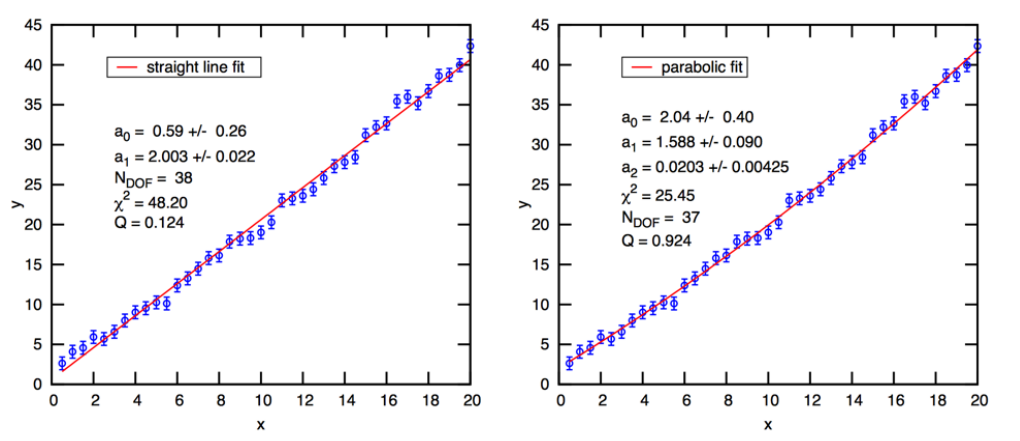

This and following examples in this section are from *[Everything you wanted to know about Data Analysis and Fitting but were afraid to ask](https://arxiv.org/pdf/1210.3781.pdf)* by Peter Young

- do we need the quadratic term here?
- both fits are "good" (acceptable $\chi^2$ and $Q$)
- inspecting the linear graph we see some systematic trends: the data is too high for small $x$ and for high $x$, while it is too low for intermediate $x$
- $\chi^2$ cannot capture this trend, because on average the data is fitted well
- trying a quadratic fit we see that it is **incompatible** with the linear fit:
     - quadratic fit coefficient $a_2$ is inconsistent with 0 within error bars
     - other fit coefficients are inconsistent also
     - this shows that a linear fit is insufficient, even though it passes the "goodness-of-fit" check
     
=> we can never prove that a model is right, only disprove it!

What about even higher orders?

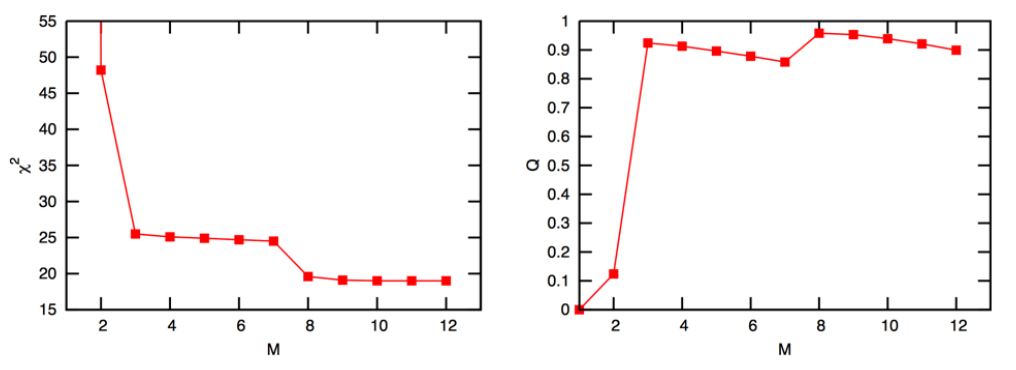


- of course, $\chi^2$ decreases with increasing number of fit parameters $M$ (remember that with $M=N$ fit parameters we would get $\chi^2=0$ => interpolation)
- there is a rapid drop in going from $M= 2$ to $M= 3$, but then a much more gradual decrease
- consistent with the quadratic fit hypothesis (the data fitted here was indeed generated from a quadratic function)
- another smaller drop at higher $M$ => most likely coincidence
- $Q$ shows similar behavior, but there is now a penalty for increasing the number of degrees of freedom

chisq_min/dof =  0.4841212262260674
Q =  0.7474398359155643


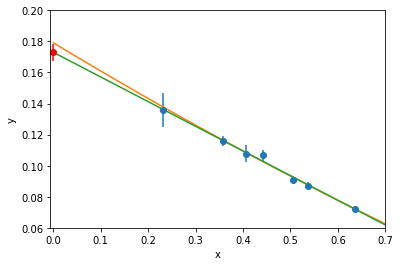

In [21]:
def chisq2(params):
    a, b, c = params
    return np.sum( (a + b*x + c*x*x - y)**2/sigmay**2 )

initial_guess = [0.2, -1, 0]
minimize(chisq2, initial_guess)

dof = len(myData) - 3
chisq_min2 = minimize(chisq2, initial_guess).fun

print("chisq_min/dof = ", chisq_min2/dof)
print("Q = ", gammaincc(dof/2, chisq_min2/2))

plt.errorbar(x, y, xerr = sigmax, yerr = sigmay, fmt='o')
plt.errorbar(0, best_fit[0], yerr=error_on_a, fmt='ro')

best_fit_quad = minimize(chisq2, initial_guess).x
plt.plot(x_for_plot, best_fit_quad[0] + best_fit_quad[1]*x_for_plot + best_fit_quad[2]*x_for_plot*x_for_plot)
plt.plot(x_for_plot, best_fit_withxerrors[0] + best_fit_withxerrors[1]*x_for_plot)

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.006, 0.7)
plt.ylim(0.06, 0.2)

plt.show()

Good practice:

- when fitting a polynomial

  => use the lowest order that fits your data (good $\chi^2$)...
  
  => ...and is consistent with the next-highest order
  
  => this includes fitting to a constant (averaging the data)
  
  
- general fitting

  => use the simplest function that fits your data consistently
  
We want to assume as little as possible about the shape of the function!

- function should be maximally smooth (data permitting)
- function should have the least number of "features" (data permitting)

#### Meaningless fits

<img src="https://imgs.xkcd.com/comics/linear_regression.png" alt="Scientific Approach" style="width: 400px;"/>

Source [xkcd](https://xkcd.com/1725/)

#### Nonlinear least squares

Best fit parameters:  [2.70860993 1.37607377 0.47821788]
Errors on fit parameters:  [0.12218271 0.13105893 0.05043957]


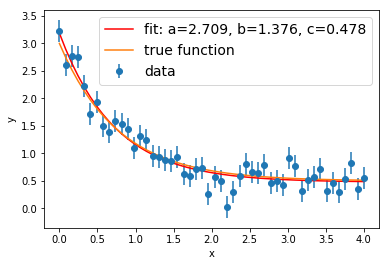

In [52]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# our nonlinear example function (3 fit parameters)
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

# produce some noisy data
xdata = np.linspace(0, 4, 50)

errY = 0.2
ydata = np.random.normal(func(xdata, 2.5, 1.3, 0.5),errY)
y_noise = errY*np.ones(len(xdata))
plt.errorbar(xdata, ydata, yerr = y_noise, fmt='o', label='data')

# do the nonlinear fit (to the true function) using scipy.optimize.curve_fit
popt, pcov = curve_fit(func, xdata, ydata, sigma = y_noise)
print("Best fit parameters: ", popt)
print("Errors on fit parameters: ", np.sqrt(np.diag(pcov)))

plt.plot(xdata, func(xdata, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(xdata, func(xdata, 2.5, 1.3, 0.5), label='true function')

plt.xlabel('x')
plt.ylabel('y')
plt.legend(fontsize = 14)
plt.show()

Problems with least square fitting:

- probability $Q$ doesn't tell you if your data is actually Gaussian
- real data is usually not Gaussian
- outliers are much more common (long tails)
- sometimes these deviations are due to not having enough data points
- but often there are additional errors which are harder to quantify

=> need **robust estimation**

For example minimize $\sum_{i=1}^N|y_i - a - bx_i|$ (assuming all $\sigma_i$ the same)

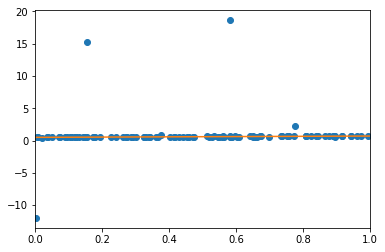

In [56]:
def f(x):
    return 0.5 + 0.2*x

num_points = 100
x = np.sort(np.random.rand(num_points))
errY = 0.02
y = np.random.normal(f(x),errY)
x_for_plot = np.linspace(0, 1, num_points)

# outliers
y[::20] = np.random.normal(f(x[::20]),1000*errY)

plt.xlim(0, 1)
plt.plot(x,y,"o")
plt.plot(x_for_plot,f(x_for_plot))
plt.show()

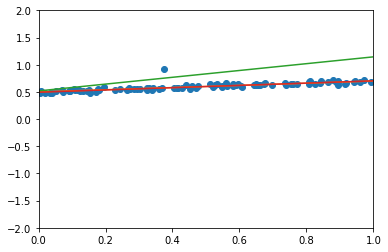

In [58]:
def chisq(params):
    a, b = params
    return np.sum( (a + b*x - y)**2/errY**2 )

def robust(params):
    a, b = params
    return np.sum( abs(a + b*x - y))

initial_guess = [0.5, 0.2]
best_chisq = minimize(chisq, initial_guess).x
best_robust = minimize(robust, initial_guess).x

plt.xlim(0, 1)
plt.ylim(-0.2, 1.2)
plt.plot(x,y,"o")
plt.plot(x_for_plot,f(x_for_plot))
plt.plot(x_for_plot, best_chisq[0] + best_chisq[1]*x_for_plot)
plt.plot(x_for_plot, best_robust[0] + best_robust[1]*x_for_plot)
plt.show()

#### Correlated data

Unfortunately, most physical data is correlated...

... in particular for Monte Carlo simulations!<br><br>


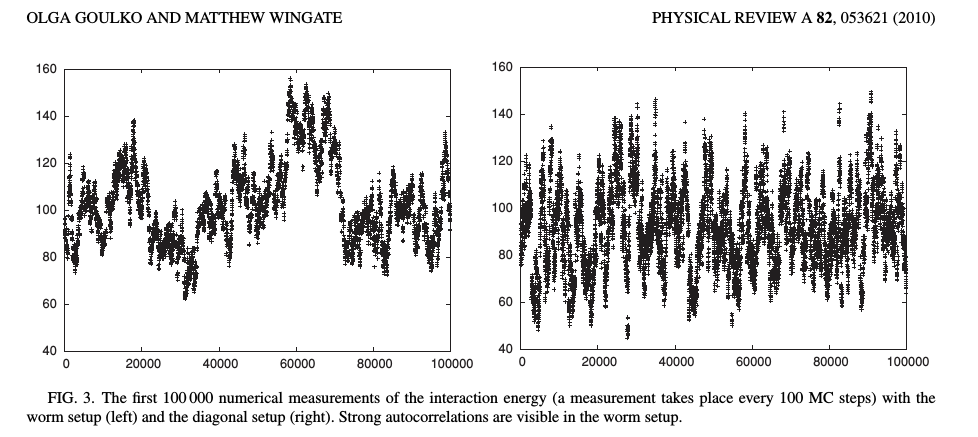

<br>

Autocorrelations: $N$ **successively** taken data points give us **less information** than $N$ independent data points

Strategy: **Blocking** / **Binning**

|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|

^ $\hspace{49mm}$ ^ $\hspace{49mm}$         ^ $\hspace{48mm}$         ^<br>
|----------------------------------------|---------------------------------------|---------------------------------------|

eventually the data points will become independent => autocorrelation length

- form **blocks** of $n$ **successive** data points and treat each block as **one data point**
- a block contains the **average** of the $n$ raw data points

Autocorrelated data:

- $n$ points contain essentially the same information as 1 data point
- binning $n$ points together doesn't increase the accuracy
- but it decreases the total number of data points!

  => error will go up

Independent data:

- $n$ points contain more information than 1 data point
- binning them together gives a more precise data point
- this offsets the fact that the total number of data points decreased

  => error will stay constant

=> Block data until the error stops increasing with increasing block size!

<br>

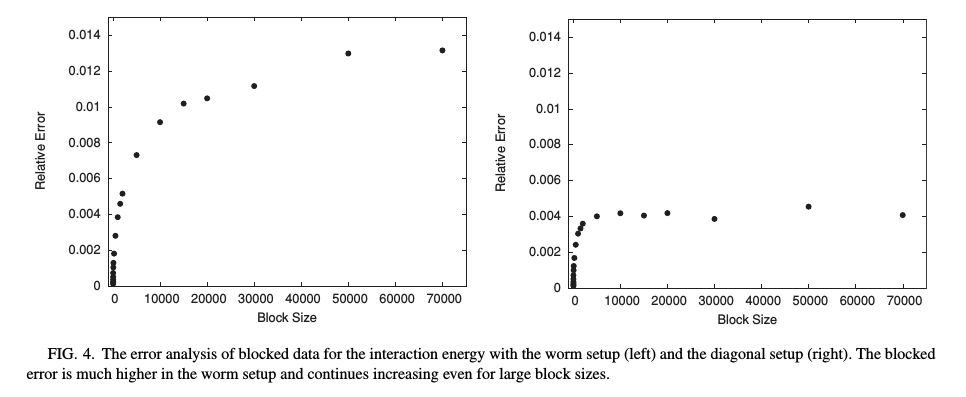


#### Jackknife and Bootstrap

Great methods to deal with "badly-behaved" data/models through [resampling](https://en.wikipedia.org/wiki/Resampling_(statistics))

- correlated data
- very non-Gaussian data
- model too complicated to make proper error analysis possible/feasible

See for example "Numerical Recipes" or *[Everything you wanted to know about Data Analysis and Fitting but were afraid to ask](https://arxiv.org/pdf/1210.3781.pdf)* by Peter Young for more information